<a href="https://colab.research.google.com/github/RPAlbuquerque/Data/blob/main/Projeto_HBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##🚀 Block 1 — Filter Geotweets by Election Keywords + Brazil Bounding Box (2018-2023)

In [ ]:
# Block 1 — Filter Geotweets by Election Keywords + Brazil Bounding Box (2018-2023) [Robust Version + Correct Output Path + Full Keywords]

import os
import gzip
import pandas as pd
import re
import glob
import concurrent.futures
from tqdm import tqdm

# --- CONFIGURATION ---
TWEET_DIR = '/n/holylabs/LABS/cga/Lab/data/geo-tweets/cga-sbg-tweets/'
YEARS = [2023, 2022, 2021, 2020, 2019, 2018]  # ordem decrescente para otimizar verificação

# Brazil bounding box
LAT_MIN = -34
LAT_MAX = +6
LON_MIN = -74
LON_MAX = -34

# OUTPUT DIR (ajustado conforme solicitado)
OUTDIR_BR = '/n/netscratch/cga/Lab/rpereiraalbuquerque/Brazilian Elections/'
os.makedirs(OUTDIR_BR, exist_ok=True)

# --- KEYWORDS (completa) ---
KEYWORDS = [
    # CAMPANHAS 2018
    'lula', 'bolsonaro', 'haddad', 'ciro', 'alckmin', 'marina', 'amoedo', 'meirelles', 'boulos',
    'daciolo', 'eymael', 'goulart', 'vera lúcia', 'manuela d’ávila', 'bivar', 'henrique meirelles',
    '#eleicoes2018', '#lulapresidente', '#bolsonaropresidente', '#bolsonaro17', '#lula13', '#haddad13', '#ciro12', '#boulos50',
    '#viravoto', '#forabolsonaro', '#foralula', '#elenão', '#elesim',
    'partido pt', 'partido pl', 'partido novo', 'partido pcb', 'partido psol', 'partido pdt',
    'partido psdb', 'partido psl', 'partido patriota', 'partido rede', 'partido solidariedade',

    # CAMPANHAS 2022
    'simone tebet', 'felipe d’avila', 'vera', 'padre kelmon', 'soraya', 'leo pericles', 'sofia manzano',
    '#eleicoes2022', '#lulapresidente', '#bolsonaropresidente', '#bolsonaro22', '#lula13', '#haddad13', '#ciro12', '#tebet',
    '#viravoto', '#forabolsonaro', '#foralula', '#eleicao', '#eleicoes', '#urnasegura', '#votoseguro', '#debatepresidencial',
    '#debateband', '#debateglobo', '#pesquisaibope', '#pesquisadatafolha', '#mito22',

    # TERMOS GERAIS
    'eleição', 'eleicoes', 'segundo turno', 'primeiro turno', 'debate', 'voto', 'votar', 'urna', 'apuração', 'campanha', 'partido', 'coligação',
    'pesquisa eleitoral', 'pesquisa', 'ibope', 'datafolha', 'tse', 'justiça eleitoral', 'boca de urna', 'mesário', 'TRE', 'votação', 'votando', 'urna eletrônica', 'voto impresso',
    'vou votar', 'votei no', 'não voto em', 'votem em', 'meu voto é', 'decidi meu voto',
    'debate presidencial', 'quem vai ganhar', 'pesquisa boca de urna', 'meu candidato é', 'meu presidente é', 'eleição no brasil', 'eleições no brasil',

    # DISCURSO PÓS-ELEITORAL
    'golpe', 'tentativa de golpe', '8 de janeiro', 'invasão', 'stf', 'tse', 'fraude eleitoral', 'urnas eletrônicas', 'urnas', 'voto auditável', 'intervenção federal',
    'militares', 'quartel', 'atos', 'manifestação', 'acampamento', 'patriota', 'patriotas', 'bolsonaristas', 'bolsonarismo',
    '#8dejaneiro', '#stf', '#tse', '#fraudeeleitoral', '#urnasegura', '#urnaseguras', '#votoauditavel', '#intervençãomilitar', '#patriotas', '#atos', '#manifestações'
]

# Compile regex
KEYWORDS = [k.lower() for k in KEYWORDS]
KEYWORDS_REGEX = re.compile(r'|'.join([re.escape(k) for k in KEYWORDS]), flags=re.IGNORECASE)

# --- FUNCTION TO FILTER A SINGLE FILE ---
def filter_tweets_from_file(filepath):
    try:
        filtered_rows = []
        basename = os.path.basename(filepath)
        n_filtered = 0

        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            header = f.readline().strip().split('\t')
            for i, line in enumerate(f):
                fields = line.strip().split('\t')
                if len(fields) == len(header):
                    lat = fields[header.index('latitude')]
                    lon = fields[header.index('longitude')]

                    # Skip if lat/lon missing
                    if lat == '' or lon == '':
                        continue

                    lat = float(lat)
                    lon = float(lon)

                    # Apply Brazil lat/lon bounding box
                    if not (LAT_MIN <= lat <= LAT_MAX and LON_MIN <= lon <= LON_MAX):
                        continue

                    # Apply keywords filter
                    text = fields[header.index('text')].lower()
                    if KEYWORDS_REGEX.search(text):
                        filtered_rows.append(fields)
                        n_filtered += 1

        # SAVE if there are filtered tweets
        if filtered_rows:
            df = pd.DataFrame(filtered_rows, columns=header)
            outfile = os.path.join(OUTDIR_BR, f'filtered_BR_{basename}')
            df.to_csv(outfile, index=False, sep='\t', compression='gzip')
            return f"✅ {basename}: {n_filtered} tweets saved"
        else:
            return f"❌ {basename}: No relevant tweets"

    except Exception as e:
        return f"⚠️ {os.path.basename(filepath)}: Error ({str(e)})"

# --- MAIN: Run in parallel (64 THREADS for robustness)
for year in YEARS:
    year_path = os.path.join(TWEET_DIR, str(year))
    filelist = sorted(glob.glob(os.path.join(year_path, '*.csv.gz')))
    print(f"\n===== Processing YEAR {year} ({len(filelist)} files) =====")

    with concurrent.futures.ThreadPoolExecutor(max_workers=52) as executor:
        results = list(tqdm(
            executor.map(filter_tweets_from_file, filelist),
            total=len(filelist),
            desc=f"Filtering geotweets for {year} (BR Bounding Box + Keywords)",
            position=0,
            leave=True
        ))

    # Summary of results after each year
    print(f"🎉 YEAR {year} completed!\n")
    for res in results:
        print(res)


===== Processing YEAR 2023 (4319 files) =====


Filtering geotweets for 2023 (BR Bounding Box + Keywords): 100%|██████████| 4319/4319 [1:01:11<00:00,  1.18it/s]


🎉 YEAR 2023 completed!

✅ 2023_1_01_00.csv.gz: 968 tweets saved
✅ 2023_1_01_01.csv.gz: 804 tweets saved
✅ 2023_1_01_02.csv.gz: 989 tweets saved
✅ 2023_1_01_03.csv.gz: 2228 tweets saved
✅ 2023_1_01_04.csv.gz: 1417 tweets saved
✅ 2023_1_01_05.csv.gz: 1139 tweets saved
✅ 2023_1_01_06.csv.gz: 395 tweets saved
✅ 2023_1_01_07.csv.gz: 283 tweets saved
✅ 2023_1_01_08.csv.gz: 310 tweets saved
✅ 2023_1_01_09.csv.gz: 413 tweets saved
✅ 2023_1_01_10.csv.gz: 715 tweets saved
✅ 2023_1_01_11.csv.gz: 765 tweets saved
✅ 2023_1_01_12.csv.gz: 1041 tweets saved
✅ 2023_1_01_13.csv.gz: 1274 tweets saved
✅ 2023_1_01_14.csv.gz: 1406 tweets saved
✅ 2023_1_01_15.csv.gz: 1456 tweets saved
✅ 2023_1_01_16.csv.gz: 1470 tweets saved
✅ 2023_1_01_17.csv.gz: 3613 tweets saved
✅ 2023_1_01_18.csv.gz: 5138 tweets saved
✅ 2023_1_01_19.csv.gz: 3877 tweets saved
✅ 2023_1_01_20.csv.gz: 5574 tweets saved
✅ 2023_1_01_21.csv.gz: 2540 tweets saved
✅ 2023_1_01_22.csv.gz: 2343 tweets saved
✅ 2023_1_01_23.csv.gz: 1705 tweets saved
✅

Filtering geotweets for 2022 (BR Bounding Box + Keywords): 100%|██████████| 8504/8504 [3:57:27<00:00,  1.68s/it]   


🎉 YEAR 2022 completed!

✅ 2022_10_01_00.csv.gz: 2409 tweets saved
✅ 2022_10_01_01.csv.gz: 2573 tweets saved
✅ 2022_10_01_02.csv.gz: 2220 tweets saved
✅ 2022_10_01_03.csv.gz: 1473 tweets saved
✅ 2022_10_01_04.csv.gz: 890 tweets saved
✅ 2022_10_01_05.csv.gz: 534 tweets saved
✅ 2022_10_01_06.csv.gz: 281 tweets saved
✅ 2022_10_01_07.csv.gz: 253 tweets saved
✅ 2022_10_01_08.csv.gz: 309 tweets saved
✅ 2022_10_01_09.csv.gz: 746 tweets saved
✅ 2022_10_01_10.csv.gz: 1298 tweets saved
✅ 2022_10_01_11.csv.gz: 1850 tweets saved
✅ 2022_10_01_12.csv.gz: 2275 tweets saved
✅ 2022_10_01_13.csv.gz: 3006 tweets saved
✅ 2022_10_01_14.csv.gz: 3285 tweets saved
✅ 2022_10_01_15.csv.gz: 3693 tweets saved
✅ 2022_10_01_16.csv.gz: 3964 tweets saved
✅ 2022_10_01_17.csv.gz: 4211 tweets saved
✅ 2022_10_01_18.csv.gz: 4142 tweets saved
✅ 2022_10_01_19.csv.gz: 4216 tweets saved
✅ 2022_10_01_20.csv.gz: 3582 tweets saved
✅ 2022_10_01_21.csv.gz: 5188 tweets saved
✅ 2022_10_01_22.csv.gz: 3368 tweets saved
✅ 2022_10_01_23.

Filtering geotweets for 2021 (BR Bounding Box + Keywords): 100%|██████████| 8451/8451 [3:43:45<00:00,  1.59s/it]   


🎉 YEAR 2021 completed!

✅ 2021_10_01_00.csv.gz: 1000 tweets saved
✅ 2021_10_01_01.csv.gz: 860 tweets saved
✅ 2021_10_01_02.csv.gz: 843 tweets saved
✅ 2021_10_01_03.csv.gz: 541 tweets saved
✅ 2021_10_01_04.csv.gz: 322 tweets saved
✅ 2021_10_01_05.csv.gz: 189 tweets saved
✅ 2021_10_01_06.csv.gz: 89 tweets saved
✅ 2021_10_01_07.csv.gz: 66 tweets saved
✅ 2021_10_01_08.csv.gz: 123 tweets saved
✅ 2021_10_01_09.csv.gz: 257 tweets saved
✅ 2021_10_01_10.csv.gz: 372 tweets saved
✅ 2021_10_01_11.csv.gz: 527 tweets saved
✅ 2021_10_01_12.csv.gz: 627 tweets saved
✅ 2021_10_01_13.csv.gz: 663 tweets saved
✅ 2021_10_01_14.csv.gz: 701 tweets saved
✅ 2021_10_01_15.csv.gz: 670 tweets saved
✅ 2021_10_01_16.csv.gz: 699 tweets saved
✅ 2021_10_01_17.csv.gz: 636 tweets saved
✅ 2021_10_01_18.csv.gz: 590 tweets saved
✅ 2021_10_01_19.csv.gz: 603 tweets saved
✅ 2021_10_01_20.csv.gz: 654 tweets saved
✅ 2021_10_01_21.csv.gz: 741 tweets saved
✅ 2021_10_01_22.csv.gz: 751 tweets saved
✅ 2021_10_01_23.csv.gz: 770 tweets

Filtering geotweets for 2020 (BR Bounding Box + Keywords): 100%|██████████| 8557/8557 [5:29:37<00:00,  2.31s/it]   


🎉 YEAR 2020 completed!

✅ 2020_10_01_00.csv.gz: 1346 tweets saved
✅ 2020_10_01_01.csv.gz: 1500 tweets saved
✅ 2020_10_01_02.csv.gz: 1750 tweets saved
✅ 2020_10_01_03.csv.gz: 1069 tweets saved
✅ 2020_10_01_04.csv.gz: 627 tweets saved
✅ 2020_10_01_05.csv.gz: 322 tweets saved
✅ 2020_10_01_06.csv.gz: 156 tweets saved
✅ 2020_10_01_07.csv.gz: 109 tweets saved
✅ 2020_10_01_08.csv.gz: 149 tweets saved
✅ 2020_10_01_09.csv.gz: 283 tweets saved
✅ 2020_10_01_10.csv.gz: 561 tweets saved
✅ 2020_10_01_11.csv.gz: 737 tweets saved
✅ 2020_10_01_12.csv.gz: 927 tweets saved
✅ 2020_10_01_13.csv.gz: 1014 tweets saved
✅ 2020_10_01_14.csv.gz: 898 tweets saved
✅ 2020_10_01_15.csv.gz: 1148 tweets saved
✅ 2020_10_01_16.csv.gz: 1128 tweets saved
✅ 2020_10_01_17.csv.gz: 1049 tweets saved
✅ 2020_10_01_18.csv.gz: 949 tweets saved
✅ 2020_10_01_19.csv.gz: 949 tweets saved
✅ 2020_10_01_20.csv.gz: 1031 tweets saved
✅ 2020_10_01_21.csv.gz: 1075 tweets saved
✅ 2020_10_01_22.csv.gz: 101 tweets saved
✅ 2020_10_02_00.csv.gz:

Filtering geotweets for 2019 (BR Bounding Box + Keywords): 100%|██████████| 8759/8759 [5:49:23<00:00,  2.39s/it]   


🎉 YEAR 2019 completed!

✅ 2019_10_01_00.csv.gz: 1606 tweets saved
✅ 2019_10_01_01.csv.gz: 1550 tweets saved
✅ 2019_10_01_02.csv.gz: 1386 tweets saved
✅ 2019_10_01_03.csv.gz: 1132 tweets saved
✅ 2019_10_01_04.csv.gz: 596 tweets saved
✅ 2019_10_01_05.csv.gz: 289 tweets saved
✅ 2019_10_01_06.csv.gz: 145 tweets saved
✅ 2019_10_01_07.csv.gz: 103 tweets saved
✅ 2019_10_01_08.csv.gz: 182 tweets saved
✅ 2019_10_01_09.csv.gz: 428 tweets saved
✅ 2019_10_01_10.csv.gz: 801 tweets saved
✅ 2019_10_01_11.csv.gz: 911 tweets saved
✅ 2019_10_01_12.csv.gz: 921 tweets saved
✅ 2019_10_01_13.csv.gz: 946 tweets saved
✅ 2019_10_01_14.csv.gz: 991 tweets saved
✅ 2019_10_01_15.csv.gz: 950 tweets saved
✅ 2019_10_01_16.csv.gz: 1049 tweets saved
✅ 2019_10_01_17.csv.gz: 933 tweets saved
✅ 2019_10_01_18.csv.gz: 941 tweets saved
✅ 2019_10_01_19.csv.gz: 871 tweets saved
✅ 2019_10_01_20.csv.gz: 1000 tweets saved
✅ 2019_10_01_21.csv.gz: 1190 tweets saved
✅ 2019_10_01_22.csv.gz: 1237 tweets saved
✅ 2019_10_01_23.csv.gz: 1

Filtering geotweets for 2018 (BR Bounding Box + Keywords): 100%|██████████| 8760/8760 [2:18:32<00:00,  1.05it/s]  

🎉 YEAR 2018 completed!

✅ 2018_10_01_00.csv.gz: 3167 tweets saved
✅ 2018_10_01_01.csv.gz: 10437 tweets saved
✅ 2018_10_01_02.csv.gz: 9491 tweets saved
✅ 2018_10_01_03.csv.gz: 6295 tweets saved
✅ 2018_10_01_04.csv.gz: 1588 tweets saved
✅ 2018_10_01_05.csv.gz: 698 tweets saved
✅ 2018_10_01_06.csv.gz: 311 tweets saved
✅ 2018_10_01_07.csv.gz: 196 tweets saved
✅ 2018_10_01_08.csv.gz: 335 tweets saved
✅ 2018_10_01_09.csv.gz: 847 tweets saved
✅ 2018_10_01_10.csv.gz: 1390 tweets saved
✅ 2018_10_01_11.csv.gz: 1702 tweets saved
✅ 2018_10_01_12.csv.gz: 1741 tweets saved
✅ 2018_10_01_13.csv.gz: 1814 tweets saved
✅ 2018_10_01_14.csv.gz: 1924 tweets saved
✅ 2018_10_01_15.csv.gz: 1933 tweets saved
✅ 2018_10_01_16.csv.gz: 1922 tweets saved
✅ 2018_10_01_17.csv.gz: 1604 tweets saved
✅ 2018_10_01_18.csv.gz: 1583 tweets saved
✅ 2018_10_01_19.csv.gz: 1854 tweets saved
✅ 2018_10_01_20.csv.gz: 1885 tweets saved
✅ 2018_10_01_21.csv.gz: 2157 tweets saved
✅ 2018_10_01_22.csv.gz: 2407 tweets saved
✅ 2018_10_01_2

In [ ]:
##🚀 Block 2 Check BR — Final (para sua pasta atual)

In [ ]:
# Block 2 Check BR — Summary of Filtered Batches (Brazilian Elections)

import os
import pandas as pd
import glob
from tqdm import tqdm
import random

# --- CONFIGURATION ---
FILTERED_DIR_BR = '/n/netscratch/cga/Lab/rpereiraalbuquerque/Brazilian Elections/'

# List filtered batch files
filtered_files = sorted(glob.glob(os.path.join(FILTERED_DIR_BR, '*.csv.gz')))
print(f"📂 Found {len(filtered_files)} filtered batch files (BR only).")

# Summary variables
total_lines = 0
columns_set = set()
all_rows = []

# Process files
for file in tqdm(filtered_files, desc="Checking filtered_batches_BR"):
    df = pd.read_csv(file, sep='\t', compression='gzip', low_memory=False)
    total_lines += len(df)

    # Save column names from first file
    if not columns_set:
        columns_set = set(df.columns.tolist())

    # Save rows for random sample (limit to first 10000 for memory safety)
    if len(all_rows) < 10000:
        all_rows.extend(df.to_dict(orient='records'))

# Output results
print("\n===== FILTERED BATCHES BR SUMMARY =====")
print(f"🗂 Total filtered batch files (BR): {len(filtered_files)}")
print(f"📝 Total number of BR tweets (lines): {total_lines:,}")
print(f"📋 Columns in dataset ({len(columns_set)} columns):")
print(columns_set)

# Show 5 random example rows
print("\n===== 5 Random Example Rows (BR) =====")
sample_rows = random.sample(all_rows, min(5, len(all_rows)))
for i, row in enumerate(sample_rows, start=1):
    print(f"\n--- Example Row {i} ---")
    for col, value in row.items():
        print(f"{col}: {value}")

📂 Found 46063 filtered batch files (BR only).


Checking filtered_batches_BR: 100%|██████████| 46063/46063 [06:20<00:00, 121.16it/s]


===== FILTERED BATCHES BR SUMMARY =====
🗂 Total filtered batch files (BR): 46063
📝 Total number of BR tweets (lines): 33,843,386
📋 Columns in dataset (25 columns):
{'friends', 'place', 'source', 'user_id', 'spatialerror', 'geom', 'status', 'longitude', 'user_location', 'tweet_lang', 'date', 'retweets', 'user_favorites', 'data_source', 'user_name', 'user_lang', 'GPS', 'tags', 'photo_url', 'followers', 'tweet_favorites', 'quoted_status_id', 'text', 'latitude', 'message_id'}

===== 5 Random Example Rows (BR) =====

--- Example Row 1 ---
message_id: 1046573437920186368
date: 2018-10-01 01:32:06
text: Boulos maconheiro
tags: nan
tweet_lang: pt
source: "<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
place: Rio de Janeiro, Brasil
geom: POLYGON((-43.795449 -23.08302,-43.795449 -22.739823,-43.087707 -22.739823,-43.087707 -23.08302,-43.795449 -23.08302))
retweets: 0.0
tweet_favorites: 0.0
photo_url: nan
quoted_status_id: -1.0
user_id: 1561736827
user_nam

In [ ]:
##🚀 Block 3 — Exploratory Analysis (complet and safe)

📂 Found 31674 CSV.GZ files to analyze.


Processing batches for Exploratory Analysis:  23%|██▎       | 7214/31674 [01:25<19:58, 20.42it/s] /tmp/ipykernel_1385109/1990738676.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
Processing batches for Exploratory Analysis:  25%|██▍       | 7889/31674 [01:41<05:55, 66.88it/s]/tmp/ipykernel_1385109/1990738676.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
Processing batches for Exploratory Analysis:  71%|███████   | 22529/31674 [07:21<02:54, 52.54it/s]/tmp/ipykernel_1385109/1990738676.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to 

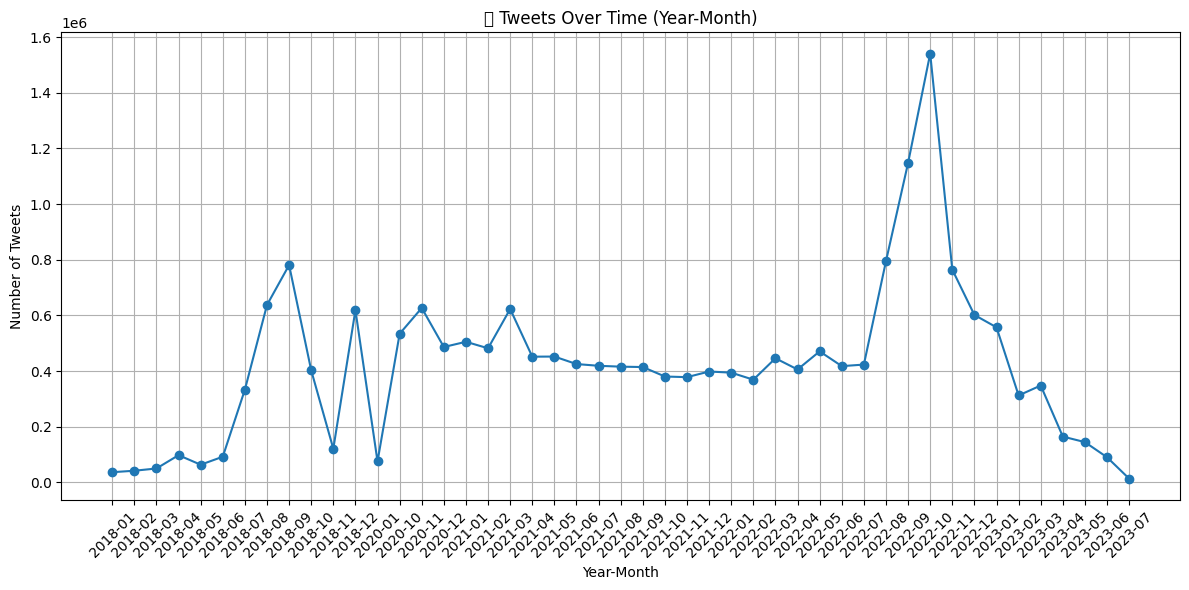

/tmp/ipykernel_1385109/1990738676.py:84: UserWarning: Glyph 127991 (\N{LABEL}) missing from current font.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127991 (\N{LABEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


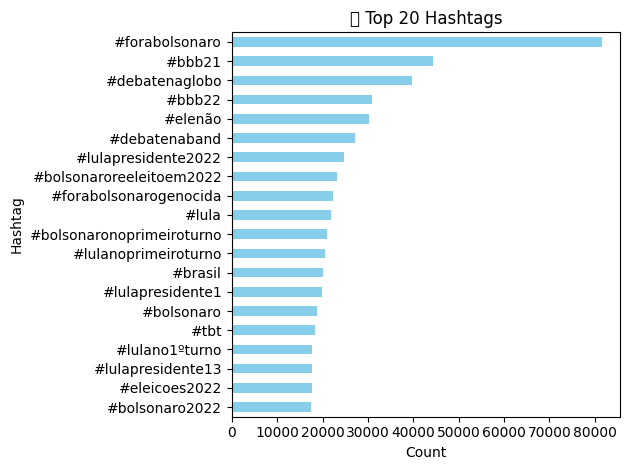

/tmp/ipykernel_1385109/1990738676.py:96: UserWarning: Glyph 128483 (\N{SPEAKING HEAD IN SILHOUETTE}) missing from current font.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128483 (\N{SPEAKING HEAD IN SILHOUETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


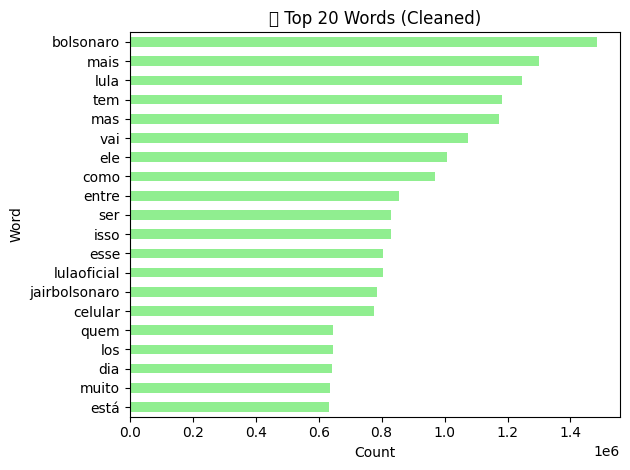

/tmp/ipykernel_1385109/1990738676.py:106: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


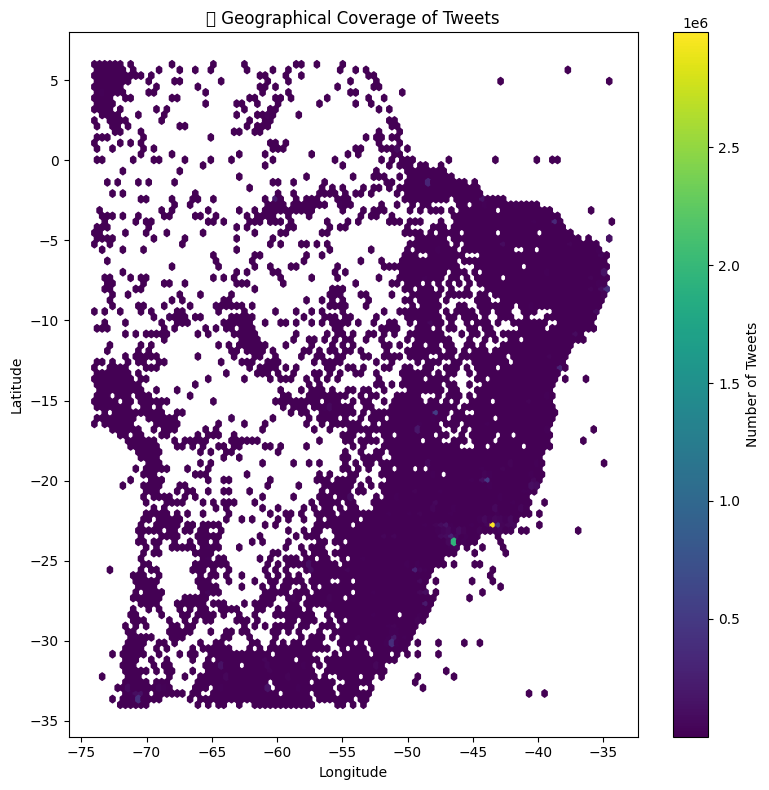


🎉 Block 3 — Exploratory Analysis completed.


In [ ]:
# Block 3 — Exploratory Analysis (FINAL — PATH CORRETO)

import os
import pandas as pd
import glob
import re
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# CONFIGURATION — PATH CORRETO AQUI
FILTERED_DIR_BR = '/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR/'
BATCH_FILES = sorted(glob.glob(os.path.join(FILTERED_DIR_BR, '*.csv.gz')))
print(f"📂 Found {len(BATCH_FILES)} CSV.GZ files to analyze.")

# Initialize counters
date_counter = Counter()
hashtag_counter = Counter()
word_counter = Counter()
latitudes = []
longitudes = []

# Define stopwords (basic Portuguese + some English common)
STOPWORDS = set([
    'de', 'da', 'do', 'das', 'dos', 'e', 'em', 'para', 'por', 'com', 'a', 'o', 'os', 'as',
    'no', 'na', 'nos', 'nas', 'que', 'se', 'um', 'uma', 'é', 'ao', 'à', 'às', 'foi', 'não',
    'eu', 'vc', 'você', 'pra', 'pro', 'nosso', 'nossa', 'meu', 'minha', 'já', 'tá', 'rt',
    'https', 'http', 'co', 'tco'
])

# Regex for hashtags
HASHTAG_REGEX = re.compile(r"#\w+")

# Process batches
for file in tqdm(BATCH_FILES, desc="Processing batches for Exploratory Analysis"):
    df = pd.read_csv(file, sep='\t', low_memory=False)

    # Block 3.1 — Temporal Distribution
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year_month'] = df['date'].dt.to_period('M').astype(str)
    date_counter.update(df['year_month'].dropna().tolist())

    # Block 3.2 — Top Hashtags
    hashtags_in_batch = df['text'].str.findall(HASHTAG_REGEX).sum()
    hashtags_in_batch = [h.lower() for h in hashtags_in_batch if h]
    hashtag_counter.update(hashtags_in_batch)

    # Block 3.3 — Top Words (cleaned)
    texts = df['text'].dropna().str.lower().tolist()
    for text in texts:
        words = re.findall(r'\b\w+\b', text)
        words_clean = [w for w in words if w not in STOPWORDS and len(w) > 2]
        word_counter.update(words_clean)

    # Block 3.4 — Geographical Coverage
    latitudes.extend(df['latitude'].dropna().tolist())
    longitudes.extend(df['longitude'].dropna().tolist())

# --- OUTPUTS ---

## Block 3.1 — Temporal Distribution
df_date = pd.DataFrame(date_counter.items(), columns=['Year-Month', 'Tweet Count'])
df_date = df_date.sort_values('Year-Month')

plt.figure(figsize=(12,6))
plt.plot(df_date['Year-Month'], df_date['Tweet Count'], marker='o')
plt.xticks(rotation=45)
plt.title('📊 Tweets Over Time (Year-Month)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.tight_layout()
plt.show()

## Block 3.2 — Top Hashtags
top_hashtags = hashtag_counter.most_common(20)
df_hashtags = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Count'])

plt.figure(figsize=(10,6))
df_hashtags.plot(kind='barh', x='Hashtag', y='Count', legend=False, color='skyblue')
plt.gca().invert_yaxis()
plt.title('🏷️ Top 20 Hashtags')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## Block 3.3 — Top Words
top_words = word_counter.most_common(20)
df_words = pd.DataFrame(top_words, columns=['Word', 'Count'])

plt.figure(figsize=(10,6))
df_words.plot(kind='barh', x='Word', y='Count', legend=False, color='lightgreen')
plt.gca().invert_yaxis()
plt.title('🗣️ Top 20 Words (Cleaned)')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## Block 3.4 — Geographical Coverage
plt.figure(figsize=(8,8))
plt.hexbin(longitudes, latitudes, gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of Tweets')
plt.title('🗺️ Geographical Coverage of Tweets')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

print("\n🎉 Block 3 — Exploratory Analysis completed.")

In [ ]:
##✅ 📦 Block 4 – Refined Filtering for 2018 Elections (Complete and Final Version)

In [ ]:
# 📌 Block 4 — Refined Filtering with Regex (Final Version with .csv.gz path)

import pandas as pd
import glob
import os
import re
from tqdm import tqdm

# ✅ Corrigir os caminhos!
input_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR/"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR_matched/"
os.makedirs(output_path, exist_ok=True)

# ✅ Palavras-chave completas
candidate_keywords = [
    r'\bbolsonar.*', r'\blula\b', r'\bhaddad\b', r'\bciro\b', r'\bdaciolo\b',
    r'\bmarina\b', r'\balckmin\b', r'\bamoedo\b', r'\bmeirelles\b',
    r'\bsoraya\b', r'\btebet\b', r'\bjanones\b', r'\bboulos\b', r'\bkelmon\b', r'\beymael\b'
]

party_keywords = [
    r'\bpt\b', r'\bpl\b', r'\bpsdb\b', r'\bpdt\b', r'\bpsol\b', r'\bmdb\b',
    r'\bpmdb\b', r'\brepublicanos\b', r'\bnovo\b', r'\bpcb\b', r'\bpstu\b', r'\bup\b'
]

election_keywords = [
    r'\beleiç.*', r'\burna\b', r'\btse\b', r'\bvoto\b', r'\bvotar\b', r'\bvotação\b',
    r'\bjustiça eleitoral\b', r'\bpresidente\b'
]

ideology_keywords = [
    r'\bmito\b', r'\blulalivre\b', r'\bfora bolsonaro\b', r'\bfora lula\b', r'\bvolta lula\b',
    r'\bbozo\b', r'\bpetista\b', r'\bbolsonarista\b',
    r'\bcomunista\b', r'\bfascista\b', r'\bnazista\b', r'\bditadura\b', r'\bdemocracia\b'
]

# ✅ Regex combinada
all_patterns = candidate_keywords + party_keywords + election_keywords + ideology_keywords
combined_pattern = '|'.join(all_patterns)

# 📂 Arquivos .csv.gz reais
csv_files = sorted(glob.glob(os.path.join(input_path, "*.csv.gz")))
print(f"📂 Found {len(csv_files)} CSV.GZ files to filter.")

# 🔁 Loop silencioso com tqdm
for file in tqdm(csv_files, desc="🔍 Applying keyword filter"):
    try:
        df = pd.read_csv(file, sep='\t', dtype=str, low_memory=False)

        if 'text' not in df.columns:
            continue

        df['matched_keywords'] = df['text'].str.lower().str.contains(combined_pattern, regex=True, na=False)
        matched_df = df[df['matched_keywords']].copy()

        if not matched_df.empty:
            filename = os.path.basename(file).replace('.csv.gz', '_matched.csv.gz')
            matched_df.to_csv(os.path.join(output_path, filename), sep='\t', index=False, compression='gzip')

    except Exception as e:
        tqdm.write(f"⚠️ Error in file {file}: {e}")

📂 Found 31674 CSV.GZ files to filter.


🔍 Applying keyword filter: 100%|██████████| 31674/31674 [10:59<00:00, 48.01it/s]  


In [ ]:
## 📌 Block 5 – Filter Only Tweets from 2018 (Until 2018-10-28)

In [ ]:
# 📌 Block 5 – Filter Only Tweets from 2018 (Until 2018-10-28)

import pandas as pd
import os
import glob
from tqdm import tqdm

# ✅ Paths
matched_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_batches_BR_matched/"
output_path_2018 = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_2018_only_until_oct28/"
os.makedirs(output_path_2018, exist_ok=True)

# 📂 Files to process
matched_files = sorted(glob.glob(os.path.join(matched_path, "*.csv.gz")))
print(f"📂 Found {len(matched_files)} matched files to check until 2018-10-28.")

# 🔁 Filtering loop
for file in tqdm(matched_files, desc="🔍 Filtering tweets until 2018-10-28"):
    try:
        df = pd.read_csv(file, sep='\t', dtype=str, low_memory=False)
        if 'date' not in df.columns:
            continue

        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df_2018 = df[(df['date'].dt.year == 2018) & (df['date'] <= '2018-10-28')].copy()

        if not df_2018.empty:
            filename = os.path.basename(file).replace(".csv.gz", "_2018pre.csv.gz")
            df_2018.to_csv(os.path.join(output_path_2018, filename), sep='\t', index=False)

    except Exception as e:
        print(f"⚠️ Error in file {file}: {e}")

📂 Found 30420 matched files to check until 2018-10-28.


🔍 Filtering tweets until 2018-10-28:   7%|▋         | 2071/30420 [00:18<03:53, 121.42it/s]/tmp/ipykernel_1714585/2043939468.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
🔍 Filtering tweets until 2018-10-28:  12%|█▏        | 3636/30420 [00:28<02:58, 149.73it/s]/tmp/ipykernel_1714585/2043939468.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
🔍 Filtering tweets until 2018-10-28:  19%|█▉        | 5746/30420 [00:43<04:07, 99.72it/s] /tmp/ipykernel_1714585/2043939468.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure p

In [ ]:
##📦 Block 5.1 — Clean First-Round Vote Data (TSE CSV)

In [ ]:
##✅ Block 6 — Assign Municipality to Filtered Tweets (2018 only)

In [ ]:
# 📌 Block 5 — Spatial Join using pyogrio (GeoJSON-friendly, no Fiona)

import os
import pandas as pd
import pyogrio
import glob
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm

# ✅ Paths
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/filtered_2018_only_until_oct28/"  # Caminho correto de entrada
geojson_parts = sorted(glob.glob("/n/netscratch/cga/Lab/rpereiraalbuquerque/BR_Census_part_*.geojson"))
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/tweets_with_municipality_2018/"
os.makedirs(output_path, exist_ok=True)

# ✅ Load all GeoJSON parts using pyogrio (sem include_geometry)
gdf_list = []
for part in geojson_parts:
    df = pyogrio.read_dataframe(part, read_geometry=True, columns=["CD_MUN", "NM_MUN"])
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    gdf_list.append(gdf)

gdf_mun = pd.concat(gdf_list, ignore_index=True)

# ✅ Process each tweet file
tweet_files = sorted(glob.glob(os.path.join(tweets_path, "*.csv.gz")))
print(f"📂 Found {len(tweet_files)} tweet files for spatial join.")

for file in tqdm(tweet_files, desc="Assigning municipalities"):
    try:
        df = pd.read_csv(file, sep="\t", low_memory=False, dtype=str)

        # Skip if lat/lon are missing
        if 'latitude' not in df.columns or 'longitude' not in df.columns:
            continue

        # Drop rows without coordinates
        df = df.dropna(subset=['latitude', 'longitude'])

        # Convert to float and filter out-of-bounds
        df['latitude'] = df['latitude'].astype(float)
        df['longitude'] = df['longitude'].astype(float)
        df = df[(df['latitude'].between(-35, 6)) & (df['longitude'].between(-75, -30))]

        # Build geometry
        df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
        gdf_tweets = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

        # Spatial join
        joined = gpd.sjoin(gdf_tweets, gdf_mun, how="left", predicate="within")
        matched = joined[~joined['CD_MUN'].isna()].copy()

        # Save only matched rows
        if not matched.empty:
            output_file = os.path.join(output_path, os.path.basename(file))
            matched.drop(columns='geometry').to_csv(output_file, sep='\t', index=False)

    except Exception as e:
        print(f"❌ Error processing file {file}: {e}")

📂 Found 6240 tweet files for spatial join.


Assigning municipalities: 100%|██████████| 6240/6240 [20:17<00:00,  5.13it/s]


In [ ]:
##✅ Validation – Spatial Join Coverage by Municipality

In [ ]:
# 📊 Validation – Summary of Tweets per Municipality (CD_MUN)

import os
import pandas as pd
import glob
from tqdm import tqdm

# ✅ Path to processed tweet files
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/tweets_with_municipality_2018/"
tweet_files = sorted(glob.glob(os.path.join(output_path, "*.csv.gz")))

# ✅ Aggregate tweets by municipality code
mun_counts = {}

for file in tqdm(tweet_files, desc="Aggregating tweets by CD_MUN"):
    try:
        df = pd.read_csv(file, sep="\t", usecols=["CD_MUN"], dtype=str)
        df = df.dropna(subset=["CD_MUN"])
        counts = df["CD_MUN"].value_counts()
        for code, count in counts.items():
            mun_counts[code] = mun_counts.get(code, 0) + count
    except Exception as e:
        print(f"❌ Error in {file}: {e}")

# ✅ Convert to DataFrame
df_mun = pd.DataFrame(list(mun_counts.items()), columns=["CD_MUN", "tweet_count"])
df_mun["CD_UF"] = df_mun["CD_MUN"].str[:2]  # Extract state code (UF)

# ✅ Summary statistics
print("📌 Total tweets matched to municipalities:", df_mun["tweet_count"].sum())
print("📌 Number of municipalities with tweets:", df_mun.shape[0])
print("📌 Top 10 municipalities by tweet volume:")
print(df_mun.sort_values("tweet_count", ascending=False).head(10))

# ✅ Optional: group by state
df_uf = df_mun.groupby("CD_UF")["tweet_count"].sum().reset_index().sort_values("tweet_count", ascending=False)
print("\n📌 Tweet distribution by state (UF):")
print(df_uf.head(10))

Aggregating tweets by CD_MUN: 100%|██████████| 6142/6142 [00:18<00:00, 327.44it/s]


📌 Total tweets matched to municipalities: 654782
📌 Number of municipalities with tweets: 3888
📌 Top 10 municipalities by tweet volume:
     CD_MUN  tweet_count CD_UF
0   3304557        81543    33
1   3513801        71957    35
2   5300108        26500    53
3   3106200        22121    31
6   4314902        17975    43
4   4106902        16288    41
9   2611606        14703    26
7   2304400        11792    23
18  2927408        11149    29
13  5208707         9345    52

📌 Tweet distribution by state (UF):
   CD_UF  tweet_count
19    35       153739
18    33       131528
16    31        53483
22    43        49760
20    41        32707
12    26        27172
21    42        26595
26    53        26500
15    29        22031
9     23        16639


In [ ]:
##✅ Código Block 6 — Aggregation by Municipality and Day

In [ ]:
# 📦 Block 6 — Aggregate Tweets by Municipality and Date

import os
import pandas as pd
import glob
from tqdm import tqdm

# ✅ Input path (from Block 5)
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/tweets_with_municipality_2018/"

# ✅ Output path
output_file = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz"

# ✅ List all tweet files with municipality
tweet_files = sorted(glob.glob(os.path.join(tweets_path, "*.csv.gz")))

# ✅ Accumulate daily stats by municipality
aggregated = []

for file in tqdm(tweet_files, desc="Aggregating per municipality-date"):
    try:
        df = pd.read_csv(file, sep="\t", dtype=str, usecols=["CD_MUN", "date", "user_id", "retweets", "latitude", "longitude"])
        df = df.dropna(subset=["CD_MUN", "date"])

        df["CD_UF"] = df["CD_MUN"].str[:2]
        df["retweets"] = pd.to_numeric(df["retweets"], errors="coerce").fillna(0).astype(int)

        # Flag de geolocalização GPS
        df["has_geo"] = (~df["latitude"].isna()) & (~df["longitude"].isna())

        # Agrupamento por CD_MUN e date
        grouped = df.groupby(["CD_MUN", "CD_UF", "date"]).agg(
            tweet_count=("user_id", "count"),
            unique_users=("user_id", "nunique"),
            retweet_count=("retweets", "sum"),
            geo_coverage=("has_geo", "sum")
        ).reset_index()

        aggregated.append(grouped)

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

# ✅ Concatenate all and export
df_final = pd.concat(aggregated, ignore_index=True)
df_final.to_csv(output_file, index=False, compression="gzip")
print(f"✅ Aggregated data saved to: {output_file}")

Aggregating per municipality-date: 100%|██████████| 6142/6142 [00:52<00:00, 117.88it/s]


✅ Aggregated data saved to: /n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz


In [ ]:
import pandas as pd

# 📥 Load the aggregated file
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz"
df = pd.read_csv(tweets_path)

# ✅ Padronizar a coluna CD_MUN
df["CD_MUN"] = df["CD_MUN"].astype(str).str.zfill(7)

# 📊 Agregar total de tweets por município
df_totals = df.groupby("CD_MUN")["tweet_count"].sum().reset_index()
df_totals = df_totals.rename(columns={"tweet_count": "total_tweets"})

# 🧮 Estatísticas descritivas
print("📈 Summary Statistics:")
print(df_totals["total_tweets"].describe())

# 🔢 Ver quantos municípios têm exatamente 1 tweet
one_tweet = (df_totals["total_tweets"] == 1).sum()
print(f"📌 Municípios com exatamente 1 tweet: {one_tweet} de {len(df_totals)}")

# 👀 Exibir amostra
print("\n🔎 Amostra dos dados:")
print(df_totals.sort_values("total_tweets").head(10))

📈 Summary Statistics:
count     3888.000000
mean       168.411008
std       1956.025542
min          1.000000
25%          2.000000
50%          8.000000
75%         37.000000
max      81543.000000
Name: total_tweets, dtype: float64
📌 Municípios com exatamente 1 tweet: 626 de 3888

🔎 Amostra dos dados:
       CD_MUN  total_tweets
1943  3169505             1
1603  3127057             1
1602  3126901             1
1600  3126604             1
1597  3125952             1
1596  3125903             1
1593  3125606             1
1589  3124807             1
546   2307635             1
1575  3122801             1


In [ ]:
##✅ Block 7 — Merge Tweets with First Round Votes (and Analyze)

In [ ]:
import pandas as pd

# 📁 Caminhos de entrada
tweets_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/aggregated_by_municipality_date_2018.csv.gz"
votes_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/election_results_2018_first_round_cleaned.csv.gz"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Elections/merged_tweets_votes_2018_round_1.csv.gz"

# 📥 Carregar dados
df_tweets = pd.read_csv(tweets_path, dtype={"CD_MUN": str})
df_votes = pd.read_csv(votes_path, dtype={"CD_MUN": str})

# ✅ Padronizar código do município (7 dígitos)
df_tweets["CD_MUN"] = df_tweets["CD_MUN"].str.zfill(7)
df_votes["CD_MUN"] = df_votes["CD_MUN"].str.zfill(7)

# 📊 Agregar tweets por município (soma de tweet_count de todas as datas)
df_tweets_agg = (
    df_tweets
    .groupby("CD_MUN", as_index=False)
    .agg(total_tweets=("tweet_count", "sum"))
)

# 🔁 Dedupe votos
#    Assumimos que df_votes já contém apenas o 1º turno e uma linha por município
#    Caso contrário, usar drop_duplicates abaixo:
df_votes_dedup = df_votes.drop_duplicates(subset=["CD_MUN"]).copy()

# 🔗 Merge (+ diagnóstico)
df_merged = pd.merge(
    df_tweets_agg,
    df_votes_dedup,
    on="CD_MUN",
    how="inner"
)
print(f"✅ Merge completo: {len(df_merged)} municípios com dados combinados de tweets e votação.")

# 💾 Salvando saída
df_merged.to_csv(output_path, index=False, compression="gzip")
print(f"✅ Arquivo salvo em: {output_path}")

# 📌 Amostra final
print("\n📌 Visualização da base final (primeiras linhas):")
print(df_merged[["CD_MUN", "NM_MUNICIPIO", "UF", "total_tweets", "votos_total", "pct_vencedor"]].head())

# 📊 Estatísticas rápidas
print("\n📈 Estatísticas descritivas de tweets por município:")
print(df_merged["total_tweets"].describe())
print(f"📌 Proporção de municípios sem tweets: {(df_merged['total_tweets']==0).mean():.2%}")

✅ Merge completo: 6 municípios com dados combinados de tweets e votação.
✅ Arquivo salvo em: /n/netscratch/cga/Lab/rpalbuquerque/Elections/merged_tweets_votes_2018_round_1.csv.gz

📌 Visualização da base final (primeiras linhas):
    CD_MUN            NM_MUNICIPIO  UF  total_tweets  votos_total  \
0  2109270      SÃO VICENTE FERRER  ma             1         9825   
1  2313005  JIJOCA DE JERICOACOARA  ce             4        10790   
2  2313757                   CEDRO  ce             1        14630   
3  3140100                  CATUJI  mg            25         5075   
4  3141009              LUISLÂNDIA  mg             5         3997   

   pct_vencedor  
0      0.795623  
1      0.440964  
2      0.441627  
3      0.652414  
4      0.794096  

📈 Estatísticas descritivas de tweets por município:
count     6.000000
mean      6.833333
std       9.086620
min       1.000000
25%       1.750000
50%       4.500000
75%       5.000000
max      25.000000
Name: total_tweets, dtype: float64
📌 Propor

In [ ]:
##📦 Block 7 — Merge Tweets with First Round Votes (Cleaned + Aggregated)

In [ ]:
print(df_merged.columns.tolist())

['CD_MUN', 'total_tweets', 'UF', 'NM_MUNICIPIO', 'votos_total', 'candidato_vencedor', 'votos_vencedor', 'pct_vencedor']


In [ ]:
print("Tweet CD_MUN sample:", df_tweets_agg["CD_MUN"].unique()[:5])
print("Vote CD_MUN sample:", df_votes["CD_MUN"].unique()[:5])

Tweet CD_MUN sample: ['1100023' '1100031' '1100049' '1100056' '1100064']
Vote CD_MUN sample: ['2210804' '2107161' '2210707' '2623167' '2937222']


In [ ]:
##📦 Block 7.1 — Diagnose Merge Coverage

In [ ]:
# 📊 Check overlap between votes and tweet municipalities
tweets_muns = set(df_tweets_agg["CD_MUN"])
votes_muns = set(df_votes["CD_MUN"])

both = tweets_muns & votes_muns
only_tweets = tweets_muns - votes_muns
only_votes = votes_muns - tweets_muns

print(f"🧮 Municipalities with tweets: {len(tweets_muns)}")
print(f"🧮 Municipalities with vote data: {len(votes_muns)}")
print(f"🔗 Municipalities in both (eligible for merge): {len(both)}")
print(f"⚠️ Municipalities with vote data but NO tweets: {len(only_votes)}")
print(f"⚠️ Municipalities with tweets but NO vote data: {len(only_tweets)}")

# 📌 Show a few unmatched examples
print("\n🔍 Example municipalities with vote data but no tweets:")
print(sorted(list(only_votes))[:10])

print("\n🔍 Example municipalities with tweets but no vote data:")
print(sorted(list(only_tweets))[:10])

🧮 Municipalities with tweets: 3888
🧮 Municipalities with vote data: 5570
🔗 Municipalities in both (eligible for merge): 6
⚠️ Municipalities with vote data but NO tweets: 5564
⚠️ Municipalities with tweets but NO vote data: 3882

🔍 Example municipalities with vote data but no tweets:
['1100019', '1100035', '1100051', '1100078', '1100094', '1100116', '1100132', '1100159', '1100175', '1100191']

🔍 Example municipalities with tweets but no vote data:
['1100023', '1100031', '1100049', '1100056', '1100064', '1100098', '1100106', '1100114', '1100122', '1100130']
